<a href="https://colab.research.google.com/github/annesjyu/NLP2/blob/main/02_NLP2_PyTorch_NN_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing NN Components Using PyTorch

PyTorch libraries can be used to build, train, test, and validate NN. The process includes defining the architecture of the network by creating layers and connections between layers, selecting activation functions, and specifying how data flows through the network.

Developers can leverage pre-defined modules like `nn.Linear` for linear layers, `nn.Conv2d` for convolutional layers, or custom modules by extending the `nn.Module` class.

The learning objectives:

1.   a single layer of NN
2.   activation functions
3.   loss functions
4.   optimizers
5.   evaluation metrics
6.   hyperparameters
7.   k-fold
8.   a real application to predict tweet sentiments



In [ ]:
import numpy as np
import torch
import torch.nn as nn

seed = 1337

''' setting the seed for random number generation in different libraries,
specifically PyTorch and NumPy. Setting the seed is an important step in
ensuring reproducibility in experiments involving random processes. '''

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

%matplotlib inline

## The Perceptron

A perceptron is essentially a single-layer NN with a linear model followed by an activation function. This is the basic unit in a NN architecture.

<img src="https://gamedevacademy.org/wp-content/uploads/2017/09/Single-Perceptron.png.webp" width=350>



In [ ]:
class Perceptron(nn.Module):
    """
    A perceptron is one linear layer
    """

    def __init__(self, input_dim, out_dim=1, cal_prob=True):
        """
        Args:
            input_dim (int): size of the input features
            out_dim (int): size of the output features
            cal_prob (bool): whether to calculate the probability or not
        """
        super(Perceptron, self).__init__()
        self.cal_prob = cal_prob
        self.fc1 = nn.Linear(in_features=input_dim,
                             out_features=out_dim,
                             bias=True)

    def forward(self, x_in):
        """The forward pass of the perceptron, i.e., the linear model.

        Args:
            x_in (torch.Tensor): an input data tensor
            x_in.shape should be (batch, num_features)
        Returns:
            the resulting tensor with tensor.shape of (batch, out_dim).
        """
        y = self.fc1(x_in)
        if self.cal_prob:
          y = torch.sigmoid(y)
        return y.squeeze()

## Activation Functions

They are **nonlinearities** introduced in the neural network to capture complex relationships in data.

1. sigmoid - $(0,1)$, differential, saturate very quickly for a majority of the inputs, might lead to **vanishing gradient problem**.

2. Hyperbolic Tangent Function (Tanh) - $[-1, 1]$, differential, also suffers from vanishing gradients problem. It is a linear transformation of the sigmoid.

3. Rectified Linear Unit (ReLU) - $[0, ∞)$, differentiable at all points except at 0, enables sparse activation.

4. softmax - $[0, 1]$, the total sum is $1$, generalizes the sigmoid function for multi-class classification tasks, differentiable, outputs a probability across multiple classes.

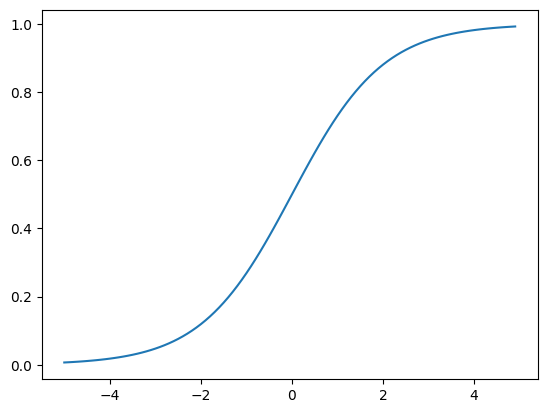

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.detach().numpy())
plt.show()

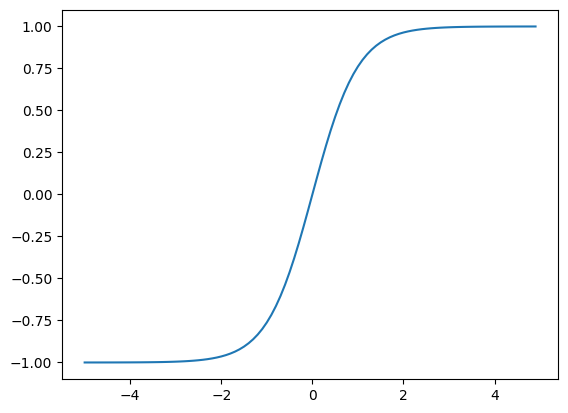

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-5., 5., 0.1)
y = torch.tanh(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

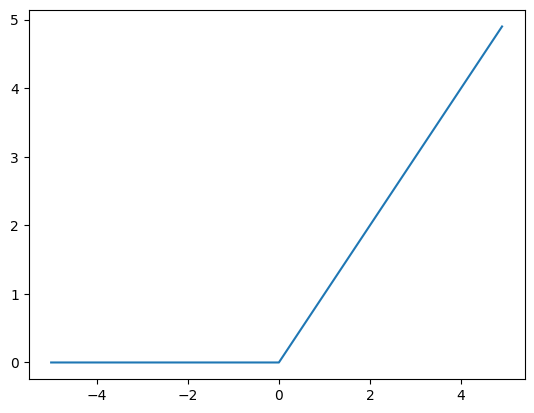

In [ ]:
import torch
import matplotlib.pyplot as plt

relu = torch.nn.ReLU()
x = torch.arange(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

### Parametric ReLU

It is a variant of ReLU, $ReLU(x) = max(0,x)$, while $PReLU(x)=max(x, ax)$ with $a$ is a leak coefficient.

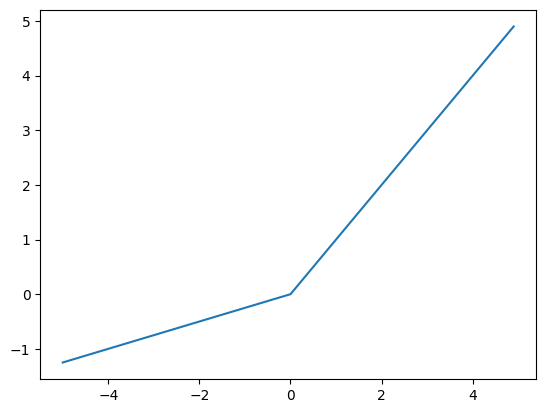

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt

# num_parameters (int, optional): It's the number of α parameters to learn. A
# value of 1 means a single α (slope of the negative part) is used for all input
# channels. If you want a separate α for each input channel, you can set it to
# the number of channels. The default is 1.
prelu = nn.PReLU(num_parameters=1)
x = torch.arange(-5., 5., 0.1)
y = prelu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

In [ ]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)

# Validate probability sum to be 1.
print(torch.sum(y_output, dim=1))

tensor([[-2.0260, -2.0655, -1.2054]])
tensor([[0.2362, 0.2271, 0.5367]])
tensor([1.])


## Loss Functions

Loss functions, also known as cost functions or objective functions, measure the difference between the predicted output of the network and the actual target values. The goal of training is to **minimize** this loss.

### MSE
For numerical targets used in regression, Mean Squared Error (MSE) can be used. Other variations are Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). They depend on how you want to calculate the distance between two points - Euclidean or Manhattan distance.

In [ ]:
import torch
import torch.nn as nn

mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
print(f'outputs={outputs}')
print(f'targets={targets}')
loss = mse_loss(outputs, targets)
loss.backward()
print(f'loss={loss}')

outputs=tensor([[-0.9122, -1.2502,  0.8032, -0.2071,  0.0544],
        [ 0.1378, -0.3889,  0.5133,  0.3319,  0.6300],
        [ 0.5815, -0.0282, -0.1744, -1.2221,  1.5787]], requires_grad=True)
targets=tensor([[ 0.5397,  1.1634,  0.6947, -1.2307,  0.6871],
        [ 1.1841, -0.2909,  1.5433,  1.8641,  1.6099],
        [ 1.3526, -0.7395, -1.1731,  0.9226,  0.0033]])
loss=1.603075385093689


### Cross-Entropy Loss

For categorical targets, the common loss function is cross-entropy loss. Entropy is from information theory. It quarlifies difference between log probability across classes, e.g., $[ H(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{M} y_{ic} \cdot \log(\hat{y}_{ic}) ]$

Where:
- $N$ is the number of samples or instances.
- $M$ is the number of possible classes.
- $y_{ic}$ is a binary indicator of whether class label $(c)$ is the correct classification for observation $i$.
- $\hat{y}_{ic}$ is the predicted probability that observation $i$ is of class $c$.

In [ ]:
import torch
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
loss.backward()
print (loss)

tensor(2.5949, grad_fn=<NllLossBackward0>)


#### Binary Cross-Entropy

In [ ]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
print(probabilities)

targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
loss.backward()
print(loss)

tensor([[0.7411],
        [0.5622],
        [0.8286],
        [0.6569]], grad_fn=<SigmoidBackward0>)
tensor(0.5958, grad_fn=<BinaryCrossEntropyBackward0>)


## Optimizer

Loss function calculates the error between prediction and target, while optimizer updates the parameter using the error. It has a parameter called learning_rate, the smaller value causes smoothers updates, and the bigger value updates parameters faster.

In [ ]:
import torch.optim as optim

input_dim = 2
lr = 0.001

model = Perceptron(input_dim=input_dim)
bce_loss = nn.BCELoss()
optimizer1 = optim.SGD(model.parameters(), lr=lr)
print(optimizer1)

optimizer2 = optim.Adam(model.parameters(), lr=lr)
print(optimizer2)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### Regulization methods

They are used to compensate overfitting problem, where a model performs well on training data but poorly on new, unseen data. The problem happens when a model learns not only the underlying patterns in the data but also the noise and random fluctuations.

* Weight regulization:
  * L1 regulization (Lasso)
  * L2 regulization (Ridge)

* Structure regulization
  * dropout

#### L1 Regulization

L1 Regularization (Lasso Regularization):

> It adds a penalty equal to the absolute value of the magnitude of the coefficients. In other words, it adds the sum of the absolute values of the weights to the loss function.

L2 Regularization (Ridge Regularization/Weight Decay):

> It adds a penalty equal to the square of the magnitude of the coefficients. This means it adds the sum of the squares of the weights to the loss function.
It encourages the weights to be small but doesn't force them to exactly zero.

#### L2 Regulization or Weight Decay

**Large Weight Decay** (Blue line): With a larger weight decay factor, the weights are more aggressively pushed towards zero compared to the smaller weight decay factor. This represents a stronger regularization effect, which can significantly reduce the magnitude of weights but might also risk underfitting if too aggressive.

**Small Weight Decay** (Red line): With a smaller weight decay factor, the weights are gently nudged towards zero. It's a more subtle form of regularization, preserving more information from the original weights while still helping to prevent overfitting.

#### An Example for L1 and L2 Regulization

Implementing L1 regularization in PyTorch requires a manual approach, as PyTorch's optimizers like SGD or Adam do not directly support an L1 penalty term. You'll need to compute the L1 penalty separately and add it to the loss function. Here's an example:

In [ ]:
import torch.optim as optim

# L2 regulization is weight_decay
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

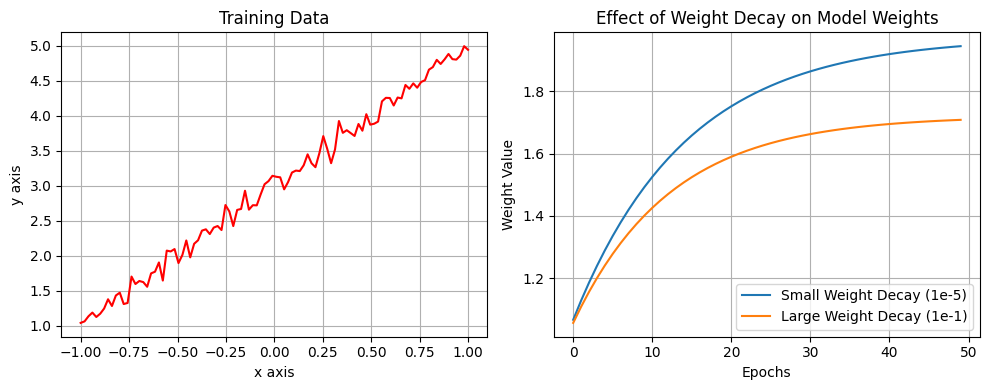

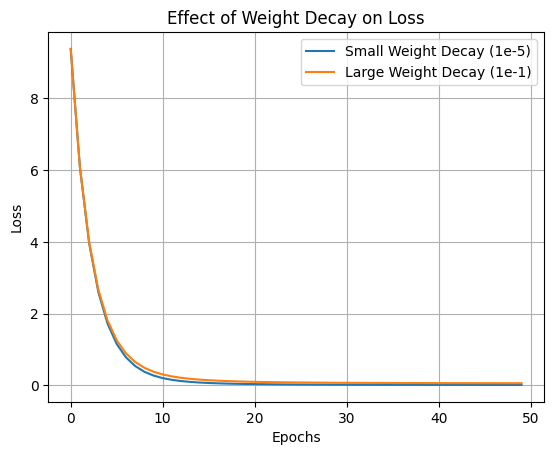

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Creating a simple linear dataset (y = 2x + 3)
x = torch.linspace(-1, 1, 100).view(-1, 1)
y = 2 * x + 3 + 0.1 * torch.randn(x.size())
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plotting the first graph on the first subplot
axes[0].plot(x.numpy(), y.numpy(), 'r')
axes[0].set_title('Training Data')
axes[0].set_xlabel('x axis')
axes[0].set_ylabel('y axis')
axes[0].grid(True)

# Simple linear model
model = nn.Linear(1, 1)

# Loss function - Mean Squared Error for regression
loss_fn = nn.MSELoss()

# Training function
def train_model(weight_decay):
    # Reset model weights for fresh training
    model.weight.data.fill_(1.0)
    model.bias.data.fill_(0.0)

    # Optimizer with specified weight decay
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)

    # Tracking weight values over epochs
    weight_values = []
    losses = []

    # Training epochs
    for _ in range(50):
        # Forward pass
        y_pred = model(x)

        # Loss calculation
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())

        # L1 Regularization
        l1_lambda = 0.01
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        # Add L1 regularized term to loss
        loss = loss + l1_lambda * l1_norm

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the current weight value
        weight_values.append(model.weight.data.item())

    return weight_values, losses

# Training with different weight decay values
weights_small_decay, losses_small_decay = train_model(weight_decay=1e-5)  # Small weight decay
weights_large_decay, losses_large_decay = train_model(weight_decay=1e-1)  # Large weight decay

axes[1].plot(weights_small_decay, label='Small Weight Decay (1e-5)')
axes[1].plot(weights_large_decay, label='Large Weight Decay (1e-1)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Weight Value')
axes[1].set_title('Effect of Weight Decay on Model Weights')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.plot(losses_small_decay, label='Small Weight Decay (1e-5)')
plt.plot(losses_large_decay, label='Large Weight Decay (1e-1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Effect of Weight Decay on Loss')
plt.legend()
plt.grid(True)
plt.show()

## A Framework to Classify Datasets

Hyperparameters:

* epochs

> how many times the full traning dataset will be seen by the model, e.g., 5.

* batches

> how many data samples will be used to update parameters at once, e.g. 10.

In [ ]:
n_epochs = 5
batch_size = 10
input_dim = 2
lr = 0.001

training_size = 700
validation_size = 150
testing_size = 150

n_batches = int(training_size / batch_size) # 70

model = Perceptron(input_dim=input_dim)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

The prediction is for a simple simulated dataset, with 2 features and 1 numerical target.

In [ ]:
for epoch in range(n_epochs):
    print(f'epoch={epoch}')
    for batch in range(n_batches):
        # Generate fake data for the batch.
        x = torch.randn(batch_size, input_dim)
        y_target = torch.randn(batch_size, 1).squeeze()
        #print(f'x={x}')
        #print(f'y_target={y_target}')

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)
        #print(f'y_pred={y_pred}')
        #print(f'y_pred.shape={y_pred.shape}')
        #print(f'y_target.shape={y_target.shape}')

        # Compute and print loss.
        loss = loss_fn(y_pred, y_target)

        # Propagate the loss value backward.
        loss.backward()

        # Trigger the optimizer to update once.
        optimizer.step()

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4


### DataLoader
`DataLoader` is used to iterate through dataset in batches. It can handle shuffling, batching, and loading the data in parallel using multiprocessing workers.

ex. can you improve the above code framework to use `DataLoader`?

# Excercise Tweet sentiment classification.

Given a set of tweets with id, tweet and sentiment, train the dataset and predict new tweet sentiment. There are a few requirements,
1. load the SMILE Twitter Emotion dataset from <a href="https://figshare.com/articles/dataset/smile_annotations_final_csv/3187909/2">tweet sentiment data</a>. The 3,085 tweets mentioning 13 Twitter handles associated with British museums was gathered between May 2013 and June 2015. It was created for the purpose of classifying emotions, expressed on Twitter towards arts and cultural experiences in museums.
  * use `torch.nn.Embedding` to vectorize texts.
2. take tweet as feature, and sentiment as target.
  * tweets are transformed to vectors before trained by the model.
  * targets are numericalized from sentiment labels:  0-anger, 1-disgust, 2-happiness, 3-surprise and 4-sadness.
3. use cross-entropy loss function.

## Vectorization
Tweets are tokenized into individual word units.
<img src="https://mlspring.files.wordpress.com/2022/11/we_love_nlp.png?w=792" width=300></img>

Tokens are transformed to vectors by mapping from word embeddings. Embeddings are stored in a dictionary like data structure, to map word to a list of float values.

<img src="https://storage.googleapis.com/coderzcolumn/static/tutorials/artificial_intelligence/word_embeddings.jpg" width=300></img>

## Load and Transform Dataset

In [ ]:
!wget https://github.com/ruslanmv/Deep-Learning-using-BERT/raw/main/Data/smile-annotations-final.csv

--2024-03-01 04:41:19--  https://github.com/ruslanmv/Deep-Learning-using-BERT/raw/main/Data/smile-annotations-final.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ruslanmv/Deep-Learning-using-BERT/main/Data/smile-annotations-final.csv [following]
--2024-03-01 04:41:19--  https://raw.githubusercontent.com/ruslanmv/Deep-Learning-using-BERT/main/Data/smile-annotations-final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429669 (420K) [text/plain]
Saving to: ‘smile-annotations-final.csv’

smile-annotations-f 100%[===================>] 419.60K  --.-KB/s    in 0.04s   

2024-03-01 04:41:19 (

In [ ]:
import pandas as pd
df = pd.read_csv('smile-annotations-final.csv',
                 names =['id', 'tweet', 'category'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3085 non-null   int64 
 1   tweet     3085 non-null   object
 2   category  3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [ ]:
df['tweet'] = df['tweet'].astype('string')
df['category'] = df['category'].astype('string')

In [ ]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: Int64

In [ ]:
# Transform sad|disgust, sad|disgust|angry to disgust;
# Transform sad|angry to sad;
df['category'] = df['category'].str.replace('sad|disgust|angry', 'disgust',
                                            regex=False)
df['category'] = df['category'].str.replace('sad|disgust', 'disgust',
                                            regex=False)
df['category'] = df['category'].str.replace('disgust|angry', 'disgust',
                                            regex=False)
df['category'] = df['category'].str.replace('sad|angry', 'sad', regex=False)
df['category'] = df['category'].str.replace('happy|surprise', 'suprise',
                                            regex=False)
df['category'] = df['category'].str.replace('happy|sad', 'sad', regex=False)

In [ ]:
df['target'] = df['category'].astype('category').cat.codes

In [ ]:
df = df[df.category!= 'nocode']

In [ ]:
dist = df.category.value_counts()
print(dist)
print(np.sum(dist))

df.target.value_counts()

happy           1137
not-relevant     214
angry             57
sad               43
surprise          35
disgust           16
suprise           11
Name: category, dtype: Int64
1513


2    1137
4     214
0      57
5      43
7      35
1      16
6      11
Name: target, dtype: int64

## Training and Testing Datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing datasets.
train_df, test_df = train_test_split(df,
                                     test_size=0.15,
                                     random_state=42,
                                     stratify=df.target.values)

In [ ]:
train_df.info()
test_df.info()

print(train_df.target.value_counts())
print(test_df.target.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 2052 to 2360
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1286 non-null   int64 
 1   tweet     1286 non-null   string
 2   category  1286 non-null   string
 3   target    1286 non-null   int8  
dtypes: int64(1), int8(1), string(2)
memory usage: 41.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 1453 to 245
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        227 non-null    int64 
 1   tweet     227 non-null    string
 2   category  227 non-null    string
 3   target    227 non-null    int8  
dtypes: int64(1), int8(1), string(2)
memory usage: 7.3 KB
2    966
4    182
0     48
5     37
7     30
1     14
6      9
Name: target, dtype: int64
2    171
4     32
0      9
5      6
7      5
1      2
6      2
Name: target, dtype: int64


### Tokenization and Vectorization

In [ ]:
import re

from torchtext.data import get_tokenizer

def tokenizer(inp_str): ## This method is one way of creating tokenizer that looks for word tokens
    return re.findall(r"\w+", inp_str)

## We'll use tokenizer available from PyTorch
tokenizer = get_tokenizer("basic_english")

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
X_train = [tokenizer(x[1]) for index,x in train_df.iterrows()]
X_test = [tokenizer(x[1]) for index,x in test_df.iterrows()]
X_comb = X_train + X_test
print(f'len_X_train={len(X_train)}')
print(f'len_X_test={len(X_test)}')
print(f'X_train[0]={X_train[0]}')
print(f'X_test[0]={X_test[0]}')

embedding_dim = 100

word2vec_model = Word2Vec(X_comb,
                          vector_size=embedding_dim,
                          window=5,
                          min_count=1,
                          workers=4)
word_vectors = word2vec_model.wv
print(word_vectors.vectors.shape)

test_word = 'thanks'
print(word_vectors.get_vector(test_word))

len_X_train=1286
len_X_test=227
X_train[0]=['@britishmuseum', 'thanks', 'so', 'much', 'for', 'doing', 'this', '.', 'i', 'absolutely', 'love', 'it', '.', '🎨📹']
X_test[0]=['@exeterliving', '@thelmahulbert', 'thank', 'you', '!']
(5884, 100)
[-0.04797502  0.1334251   0.02657704  0.10833604  0.04165592 -0.3387237
  0.15919717  0.41280246 -0.0920923  -0.20143549 -0.07220072 -0.27372986
 -0.06112517  0.13569607  0.07373121 -0.19932711  0.06663275 -0.17597759
 -0.08476263 -0.4159412   0.07136341  0.16341098  0.20311889 -0.07123322
 -0.08111148  0.02078133 -0.16993533 -0.09177081 -0.1353869  -0.05584313
  0.23165616 -0.04103705  0.19811466 -0.2512971  -0.08183967  0.252294
  0.06456909 -0.15088992 -0.1949821  -0.33021274 -0.03112774 -0.16355705
 -0.12198429  0.03363736  0.14135776 -0.08883438 -0.16998616 -0.06488236
  0.06828587  0.14955811  0.05370075 -0.2046684  -0.04195133 -0.06738395
 -0.07936883  0.04148035  0.17300536 -0.07811309 -0.14714037  0.06437077
  0.05178982 -0.02520544  0.0750751

In [ ]:
# Initialize an empty list to hold all text vectors
def get_text_embedding_matrix(texts):
  text_vectors = []
  for text in texts:
      vectors = []
      for word in text:
          try:
              vectors.append(word_vectors.get_vector(word))
          except KeyError:
              pass  # or handle unknown word case

      if vectors:
          text_vector = np.mean(vectors, axis=0)
          text_vectors.append(text_vector)
      else:
          text_vectors.append(np.zeros(word_vectors.vector_size))

  text_vectors_matrix = np.array(text_vectors)

  print(f"Text Vectors Matrix: {text_vectors_matrix.shape}")
  #print(text_vectors_matrix)
  return text_vectors_matrix

train_text_vectors = get_text_embedding_matrix(X_train)
test_text_vectors = get_text_embedding_matrix(X_test)

Text Vectors Matrix: (1286, 100)
Text Vectors Matrix: (227, 100)


### Dimensions

Given the word vector dim = 100,
* a word token embedding dimension = (1, 100);
* a tweet with 10 words dimension = (10, 100);
* a batch with 32 tweets dimension = (32, 10, 100).

For simplicity, the above batch dimension = (32, 100), since the average vector value of all the words in one tweet represents the tweet embedding.

### Training

In [ ]:
n_epochs = 5
batch_size = 32
lr = 0.001
weight_decay=1e-5

input_dim = embedding_dim
training_size = len(X_train)
testing_size = len(X_test)

n_batches = int(training_size / batch_size)

# The accurate way is to calculate probability instead of logit.
model = Perceptron(input_dim=input_dim, cal_prob=False)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

### DataLoader

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

x_train_tensor = torch.tensor(train_text_vectors).to(torch.float32)
y_train_tensor = torch.tensor(train_df.target.values).to(torch.float32)

print(f'x_train_tensor.shape={x_train_tensor.shape}')
print(f'y_train_tensor.shape={y_train_tensor.shape}')

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=False)

x_train_tensor.shape=torch.Size([1286, 100])
y_train_tensor.shape=torch.Size([1286])


### Training Starts

In [ ]:
for epoch in range(n_epochs):
    print(f'epoch={epoch}')
    # Set the model to training mode
    model.train()
    for batch_idx, (x_tweets, y_target) in enumerate(train_loader):
        #print(f'x={x_tweets.shape}')
        #print(f'y_target={y_target}')

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x_tweets)
        #print(f'y_pred.shape={y_pred.shape}')
        #print(f'y_pred={y_pred}')

        # Compute and print loss.
        loss = loss_fn(y_pred, y_target)

        # Propagate the loss value backward.
        loss.backward()

        # Trigger the optimizer to update once.
        optimizer.step()

        if batch_idx % 10 == 0:
          print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

epoch=0
Epoch: 0, Batch: 0, Loss: 7.104066848754883
Epoch: 0, Batch: 10, Loss: 7.940566539764404
Epoch: 0, Batch: 20, Loss: 6.643784999847412
Epoch: 0, Batch: 30, Loss: 3.9466938972473145
Epoch: 0, Batch: 40, Loss: 5.249683856964111
epoch=1
Epoch: 1, Batch: 0, Loss: 4.063480854034424
Epoch: 1, Batch: 10, Loss: 5.143594264984131
Epoch: 1, Batch: 20, Loss: 4.207381248474121
Epoch: 1, Batch: 30, Loss: 2.2536568641662598
Epoch: 1, Batch: 40, Loss: 3.732974052429199
epoch=2
Epoch: 2, Batch: 0, Loss: 2.3332386016845703
Epoch: 2, Batch: 10, Loss: 3.5790963172912598
Epoch: 2, Batch: 20, Loss: 2.914829730987549
Epoch: 2, Batch: 30, Loss: 1.5250487327575684
Epoch: 2, Batch: 40, Loss: 3.0606510639190674
epoch=3
Epoch: 3, Batch: 0, Loss: 1.5118651390075684
Epoch: 3, Batch: 10, Loss: 2.826937437057495
Epoch: 3, Batch: 20, Loss: 2.3277502059936523
Epoch: 3, Batch: 30, Loss: 1.3095542192459106
Epoch: 3, Batch: 40, Loss: 2.8301239013671875
epoch=4
Epoch: 4, Batch: 0, Loss: 1.18459153175354
Epoch: 4, B

### A Few Improvements

* can you change the target from logits to one-hot encoded vectors? In this case, any predicted result is a vector of probabilities.

* can you improve the code to work in the CUDA mode as well?

### Testing and Evaluation

* Add a testing step to evaluate the model using `X_test` data.

* Use proper evalution metrics to check model.